# Mixtral 8X22B Tutorial

## Introduction

When OpenAI released ChatGPT in 2022, many wondered if other companies could ever compete with such a good product backed by a behemoth like Microsoft. When everyone had their attention on other large techies such as Google and Meta to deliver, out came Mistral AI with their 7B model in 2023, which outperformed all open-source LLMs with almost twice the size. 

Since then, Mistral AI became a _big player_ in the LLM race that is happening at breakneck speed. In April 2024, they released Mixtral 8X22B, a model that easily outperformed then-best open-source Llama 2 on many benchmarks. In this tutorial, we will discuss the model in detail from architecture to setting up a RAG pipeline with it.

## What makes Mixtral 8x22B model unique?

- Sparse Mixture of experts model (SMoE)
- Only uses 39B active parameters out of 141B
- Fluent in five languages: English, German, French, Spanish and Italian
- Natively capable of function calling
- 64k context window
- Truly open source - Apache 2.0 license
- Faster than any dense 70B parameter models due to its sparse activation patterns
- Making it an excellent basis for fine-tuning
- Strong math and coding capabilities
- The benchmarks speak for themselves
- Wins over Llama 2 and Command R+ in terms of MMLU, HellaS, WinoG, Arc C 5, Arc C 25, TriQA, NaturalQS - reasoning and knowledge
- Superior to Llama 2 in four non-English languages
- And its defining point - it is significantly better than Command R+ and Llama 2 in terms of math and coding. Benchmarks: HumanEval pass@1, MBPP pass@1, GSM8K maj@1 (5 shot), GSM8K maj@8 (8-shot) and Math maj@4.

## The architecture behind Mixtral 8X22B - SMoE explained

- Chooses only 2 experts during inference
- Has 8 experts, with 22 billion parameters each
- The scale of the model is one of the most important factors for better model quality.
- Training a larger model for a fewer steps is better than training a small model for more steps when compute budget is constrained
- Mixture of Experts allows models to be trained with far less compute, meaning you can scale up model or dataset size dramatically with the same compute budget as a dense model
- A MoE model should achieve the same quality as its dense counterpart much faster during pretraining

- To better understand the SMoE architecture, let's use an analogy
- Imagine a team of 100 people working on a project.
- In traditional neural nets: the entire team analyzes all the information and tries to chip in on every task even if it isn't relevant to their expertise
- In SMoE architecture: This is like having a smart team leader who assigns tasks based on expertise. The leader (router) directs each piece of information (token) to a small group of specialists (experts) based suited to handle it. Only the right experts work on the problem, making the process much faster and more focused.

- SMoE models consist of the following components:
    1. Experts: smaller neural networks compared to the full model. Mixtral uses 8 experts with 22b params each. Each expert network is trained to handle specific type of information or task. For example, one of the Mixtral experts might handle math and logic queries, while another might handle French.
    2. Router (gating network): The gating network determines which tokes are sent to which expert. The router typically uses a small neural network itself to consider factors like the content of the token and the current context to make the decision. How to route a token to an expert is one of the big decisions when working with any MoE model.
    3. Aggregation: Once the experts process their assigned tokens, their outputs are combined. This can be done in various ways such as plain averaging or using a more complex weighting strategy.


Benefits of SMoE:
- Eficiency: By only activating a small subset of experts for each input, SMoE reduces computational costs and improves processing speed
- Scalability: You can easily add more experts to the pool without significantly impacting training or inference time. This allows you to build very large models with high capacity.
- Accuracy: Specializing experts to certain tasks can lead to better performance compared to a single, monolithic network. The benchmarks showed that Mixtral was particularly good at language, math and coding tasks and I guess, we can credit the achieve to its certain experts.

Challenges of SMoE:
- Training complexity: Training an SMoE can be very challenging due to the added complexity of the router and expert coordination
- Finding the right experts: Deciding on the appropriate number and type of experts is crucial for optimal performance
- Research area: SMoE is a relatively new model architecture so it needs  a lot of research to address its issues
- Heavy on memory: due to its architecture, all parameters of the model must be loaded into memory during inference, taking up all of your GPU vRAM. To run inference with Mixtral 8X22B, you need a GPU with at least 300GB of memory.

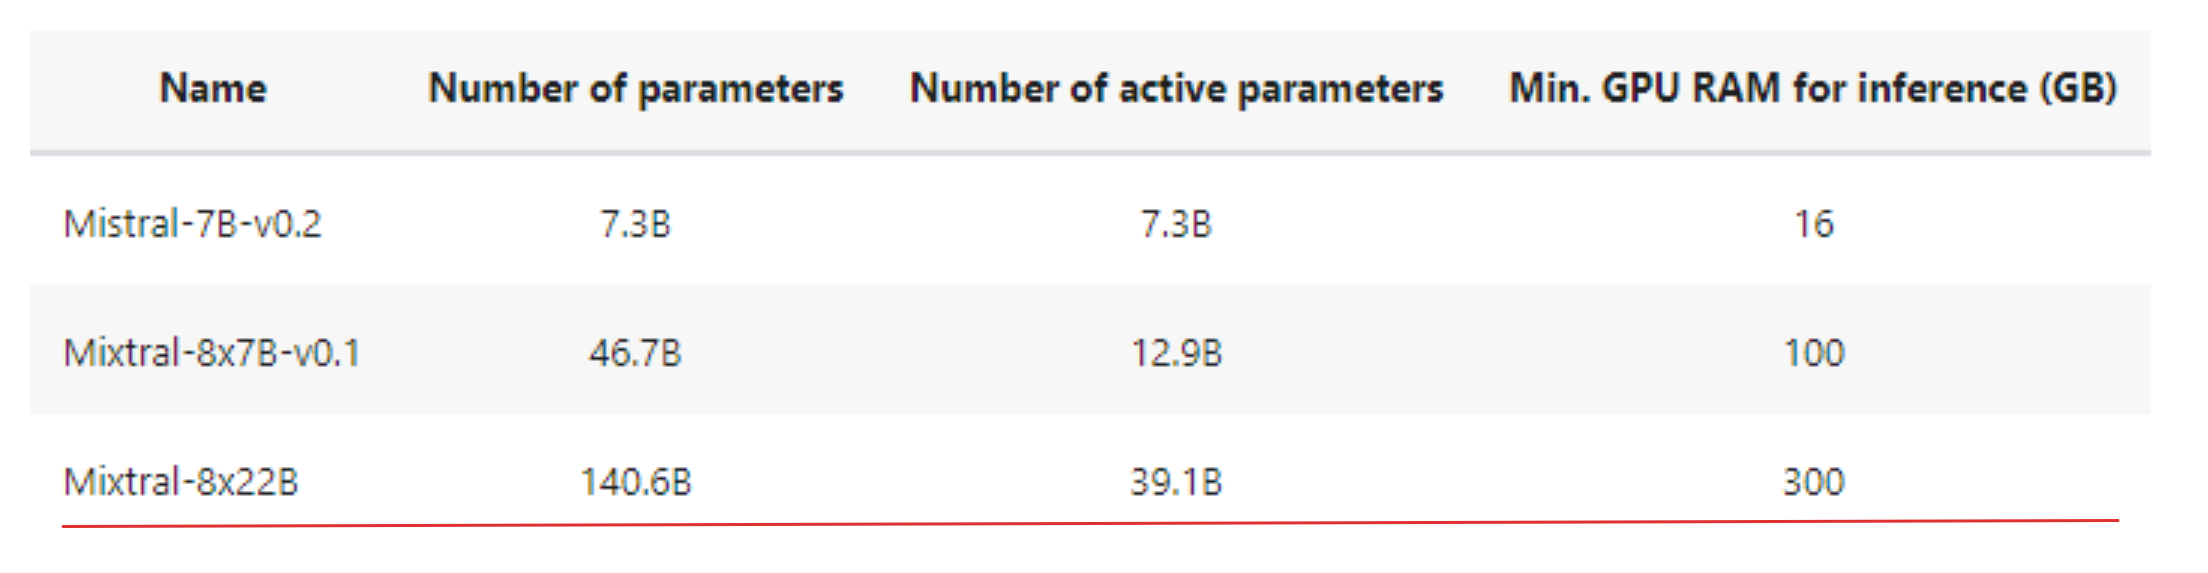

## Getting started with Mixtral 8x22B

### Account setup

### Environment setup

```bash
$ conda env create -n mistral python==3.8 -y
$ conda activate mistral
$ pip install mistralai
$ pip install python-dotenv ipykernel
$ ipython kernel install --user --name=mistral
```

```
$ touch .env
```

```
MISTRAL_API_KEY=YOUR_KEY_HERE
```

```
$ echo ".*env" >> .gitignore
```

In [7]:
import os

from dotenv import load_dotenv

load_dotenv()

api_key = os.environ["MISTRAL_API_KEY"]

### Using a chat client

In [21]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

model = "open-mixtral-8x22b"

client = MistralClient(api_key=api_key)
message = "Who is the best French football player of all time?"
chat_response = client.chat(
    model=model,
    messages=[ChatMessage(role="user", content=message)],
)

print(chat_response.choices[0].message.content[:300])

Determining the "best" French football player of all time can be quite subjective and depends on personal preferences, as well as what specific criteria one uses to define "best." However, one of the most frequently mentioned players in such discussions is Zinedine Zidane.

Zinedine Zidane, often re


## Practical applications

### Text generation

In [9]:
messages = [ChatMessage(role="user", content="What led to Zidane's ban from football?")]

# With streaming
stream_response = client.chat_stream(model=model, messages=messages)

for chunk in stream_response:
    print(chunk.choices[0].delta.content, end="")

Zinedine Zidane, the former French football player, was banned from football for several matches on a few occasions during his career, but the most notable one was the incident in the 2006 FIFA World Cup Final.

In the 2006 World Cup Final against Italy, Zidane was involved in an altercation with Italian defender Marco Materazzi. In the second half of extra time, with the score tied at 1-1, Materazzi and Zidane were seen exchanging words. Zidane then turned and headbutted Materazzi in the chest. The referee, Horacio Elizondo, did not see the incident initially but was informed by the fourth official, Luis Medina Cantalejo. After a brief consultation, Elizondo showed Zidane a red card, and he was sent off. Italy went on to win the match 5-3 in a penalty shootout.

Following the incident, Zidane was widely criticized for his actions. He was banned for three matches by FIFA, which was the maximum allowed under the rules at the time. He also announced his retirement from professional footb

![](images/zidane.gif)

### Generating embeddings

In [10]:
to_embed = ["Is Messi better than Zidane?", "How about Ronaldo?"]

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=to_embed,
)

type(embeddings_batch_response)

mistralai.models.embeddings.EmbeddingResponse

In [11]:
len(embeddings_batch_response.data)

2

In [12]:
first_sentence = embeddings_batch_response.data[0]

len(first_sentence.embedding)  # Embedding dimension

1024

Note that higher dimensional embs might better capture text information and imrpove performance but they require more compute for hosting and inference

### Paraphrase detection using embeddings

In [13]:
def get_text_embedding(input, client):
    embeddings_batch_response = client.embeddings(model="mistral-embed", input=input)

    return embeddings_batch_response.data[0].embedding

In [14]:
import itertools

from sklearn.metrics.pairwise import euclidean_distances

sentences = [
    "What led to Zidane's ban from football?",
    "This is a totally different sentence.",
    "What caused Zidane to get banned from football?",
]

sentence_embeddings = [get_text_embedding(t, client) for t in sentences]

sentence_embeddings_pairs = list(itertools.combinations(sentence_embeddings, 2))
sentence_pairs = list(itertools.combinations(sentences, 2))

for s, e in zip(sentence_pairs, sentence_embeddings_pairs):
    print(s, euclidean_distances([e[0]], [e[1]]))

("What led to Zidane's ban from football?", 'This is a totally different sentence.') [[0.84503319]]
("What led to Zidane's ban from football?", 'What caused Zidane to get banned from football?') [[0.28662641]]
('This is a totally different sentence.', 'What caused Zidane to get banned from football?') [[0.83794058]]


### Function calling

## Using Mixtral 8X22B in a RAG pipeline

```
$ pip install faiss-cpu
```

In [2]:
import os

import numpy as np
from mistralai.client import ChatMessage, MistralClient

In [32]:
from pathlib import Path

file = Path("snowpark_tutorial.txt")
tutorial_text = file.read_text()

In [35]:
chunk_size = 512
chunks = [
    tutorial_text[i : i + chunk_size] for i in range(0, len(tutorial_text), chunk_size)
]

len(chunks)

3

In [36]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(model="mistral-embed", input=input)
    return embeddings_batch_response.data[0].embedding


text_embeddings = np.array([get_text_embedding(chunk) for chunk in chunks])

In [37]:
import faiss

d = text_embeddings.shape[1]
index = faiss.IndexFlatL2(d)

index.add(text_embeddings)

In [38]:
question = "What is Snowpark?"

question_embeddings = np.array([get_text_embedding(question)])

In [39]:
D, I = index.search(question_embeddings, k=2)  # distance, index

retrieved_chunk = [chunks[i] for i in I.tolist()[0]]

In [40]:
prompt = f"""
Context information is below.
---------------------
{retrieved_chunk}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {question}
Answer:
"""

In [41]:
def run_mistral(user_message, model="open-mixtral-8x22b"):
    messages = [ChatMessage(role="user", content=user_message)]
    chat_response = client.chat(model=model, messages=messages)
    return chat_response.choices[0].message.content


run_mistral(prompt)

"Snowpark is a set of libraries and runtimes that allows users to securely use programming languages such as Python, Java, and Scala to process data directly within Snowflake's cloud platform. This eliminates the need to move data outside Snowflake for processing, improving efficiency and security. Some of its key benefits include processing data within Snowflake, improved performance through Snowflake's elastic and serverless architecture, reduced costs and technology overhead, and the ability to work with SQL databases from any environment using Snowpark's APIs."

## Conclusion